## 深度学习中的优化方法
梯度、动量、NAG的比较

In [1]:
import pandas as pd 
import numpy as np

import math

% matplotlib inline
import matplotlib.pyplot as plt

#显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [3]:
#读取数据
dpath = "./data/"
df = pd.read_csv(dpath + "Advertising.csv")

#通过观察前5行，了解数据每列（特征）的概况
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [4]:
#去掉索引列，与预测模型无关
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

# 从原始数据中分离输入特征x和输出y
y = df['sales']
X = df.drop('sales', axis = 1)

## 特征标准化，学习率为0.1

In [5]:
# 数据标准化
# 本数据集中3个特征的单位相同，可以不做特征缩放，不影响正则
# 但3个特征的取值范围不同，如果采用梯度下降/随机梯度下降法求解，
# 还是将所有特征的取值范围缩放到相同区间
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()

# 对训练数据，先调用fit方法训练模型，得到模型参数；然后对训练数据和测试数据进行transform
X = ss_X.fit_transform(X)

In [6]:
#将数据分割训练数据与测试数据
from sklearn.model_selection import train_test_split

# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)
#X_train.shape

In [7]:
# 方便可视化,只取两个特征，同时去掉截距项
X_train_2d = np.delete(X_train, -1, axis=1)

y_train_mean = y_train.mean()
y_train_2d = y_train - y_train_mean

### 梯度下降

In [8]:
# 目标函数
def obj_ols(X, y, w):
    N = X.shape[0]  # 样本数目
    y_pred = np.dot(X, w)
    res = y - y_pred
    return np.sum(res ** 2)/N # 目标函数

In [9]:
# 目标函数的一阶导数
def grad_OLS(X, y, w):
    N = X.shape[0]  # 样本数目
    X_transpose = np.transpose(X)
    y_pred = np.dot(X, w)
    res = y_pred - y 
    
    #2(Xw-y)*X^T
    grad =  2*np.dot(X_transpose , res)/N 
    return grad

In [10]:
# 梯度下降法
# 给定起始点与目标函数的一阶导函数，求在epochs次迭代中x的更新值
def bgd_ols(X, y, w_start, df, max_epochs=10000, lr=0.1, epsilon = 0.0001):
    """
    :param X, y: 训练数据
    :param w_start: x的起始点
    :param df: 目标函数的一阶导函数
    :param max_epochs: 最大迭代次数
    :param lr: 学习率
    :return: 每次迭代后的位置（包括起始点），和对应目标函数值
    """
    #初始化
    ws = []      # 参数
    Js = []      # 目标函数
    D = X.shape[1]  # 特征维度
    
    w = w_start
    row = []
    for j in range(D):
        row.append(w[j])
    ws.append(row)
    
    J = obj_ols(X, y,w)
    Js.append(J)
    
    for iter in range(1, max_epochs+1):
        dw = df(X, y, w) #计算梯度
        
        w += - dw * lr   #根据梯度，更新参数
        
        row = []
        for j in range(D):
            row.append(w[j])
        ws.append(row)
        
        #判断目标函数是否收敛
        J = obj_ols(X, y,w)
        Js.append(J)
        #print("iter %s | J: %.3f" % (iter, J))
        #print( w)
        #print( dw)
       
        #判断是否收敛
        if (abs(Js[iter-1]-J)/Js[iter-1] < epsilon or abs(Js[iter-1]-J)/Js[iter-1]< epsilon or Js[iter] <epsilon): 
            break
            
    return ws, Js

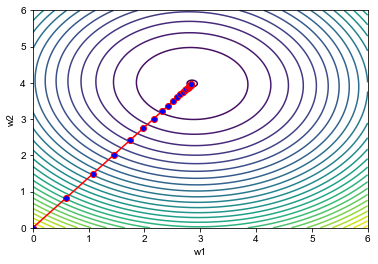

In [13]:
n = 256
w1 = np.linspace(0, 6, n)
w2 = np.linspace(0, 6, n)
Js_grid = np.zeros((n, n))
w_2d = np.zeros(2)
 
# 把w1,w2数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W1, W2 = np.meshgrid(w1, w2)

for i in range(0,n):
    w_2d[0] = w1[i]
    for j in range(0,n):
        w_2d[1] = w2[j]
        Js_grid[i,j] = obj_ols(X_train_2d, y_train_2d, w_2d)
        
    
# 等高线
plt.contour(W1, W2, Js_grid, 30)

#梯度下降轨迹
#初始化
d2 = X_train_2d.shape[1]  # 特征维度
w_start = np.zeros(d2)  #参数初始化

#梯度下降
lr = 0.1
ws_bgd, Js_bgd = bgd_ols(X_train_2d, y_train_2d, w_start, grad_OLS, lr =  lr)


ws_np_bgd = np.mat(ws_bgd)
plt.plot(ws_np_bgd[:,1], ws_np_bgd[:,0],  color='r',markerfacecolor='blue',marker='o')  

plt.xlabel(u'w1')
plt.ylabel(u'w2')
# 显示图表
plt.show()

[3.964031917243299, 2.8433179133159645]


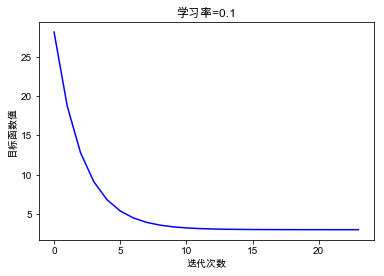

In [17]:
#显示
n_iter = len(ws_bgd)
plt.plot(range(n_iter), Js_bgd, "b-")
plt.xlabel(u'迭代次数')
plt.ylabel(u'目标函数值')
plt.title(u'学习率='+ str(lr))

print(ws_bgd[n_iter-1])

### 动量法

In [19]:
# momentum
# 给定起始点与目标函数的一阶导函数，求在epochs次迭代中x的更新值
def bgd_momentum_ols(X, y, w_start, df, max_epochs=10000, lr=0.1, epsilon = 0.0001, rpo= 0.5):
    """
    :param X, y: 训练数据
    :param w_start: x的起始点
    :param df: 目标函数的一阶导函数
    :param max_epochs: 最大迭代次数
    :param lr: 学习率
    :return: 每次迭代后的位置（包括起始点），和对应目标函数值
    """
    #初始化
    ws = []      # 参数
    Js = []      # 目标函数
    D = X.shape[1]  # 特征维度
    
    w = w_start
    row = []
    for j in range(D):
        row.append(w[j])
    ws.append(row)
    
    J = obj_ols(X, y,w)
    Js.append(J)
    
    v = 0
    for iter in range(1, max_epochs+1):
        dw = df(X, y, w) #计算梯度
        
        #计算动量
        v = rpo * v -lr* dw  
        #v =  dw

        #根据动量，更新参数
        w += v
 
        row = []
        for j in range(D):
            row.append(w[j])
        ws.append(row)
        
        #判断目标函数是否收敛
        J = obj_ols(X, y,w)
        Js.append(J)
        #print("iter %s | J: %.3f" % (iter, J))
        #print( w)
        #print( dw)
       
        #判断是否收敛
        if (np.linalg.norm(dw) < epsilon or abs(Js[iter-1]-J)/Js[iter-1] < epsilon): 
            break
            
    return ws, Js

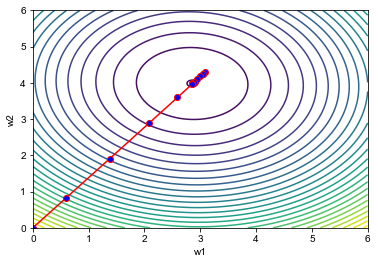

In [20]:
n = 256
w1 = np.linspace(0, 6, n)
w2 = np.linspace(0, 6, n)
Js_grid = np.zeros((n, n))
w_2d = np.zeros(2)
 
# 把w1,w2数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W1, W2 = np.meshgrid(w1, w2)

for i in range(0,n):
    w_2d[0] = w1[i]
    for j in range(0,n):
        w_2d[1] = w2[j]
        Js_grid[i,j] = obj_ols(X_train_2d, y_train_2d, w_2d)
        
    
# 等高线
plt.contour(W1, W2, Js_grid, 30)

#梯度下降轨迹
#初始化
d2 = X_train_2d.shape[1]  # 特征维度
w_start = np.zeros(d2)  #参数初始化

#梯度下降
lr = 0.1
ws_bgd, Js_bgd = bgd_momentum_ols(X_train_2d, y_train_2d, w_start, grad_OLS, lr =  lr)


ws_np_bgd = np.mat(ws_bgd)
plt.plot(ws_np_bgd[:,1], ws_np_bgd[:,0],  color='r',markerfacecolor='blue',marker='o')  

plt.xlabel(u'w1')
plt.ylabel(u'w2')
# 显示图表
plt.show()

在初始阶段，由于相邻两次梯度一次，动量法加快收敛；最后阶段虽然overshooting，但相邻两次梯度方向相反，最后能收敛到局极值。

[3.967667184038133, 2.8438180429446156]


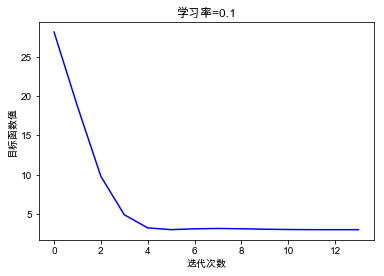

In [21]:
#显示
#lr = 0.1
n_iter = len(ws_bgd)
plt.plot(range(n_iter), Js_bgd, "b-")
plt.xlabel(u'迭代次数')
plt.ylabel(u'目标函数值')
plt.title(u'学习率='+ str(lr))

print(ws_bgd[n_iter-1])

### Nesterov 动量法（Nesterov Accelerated Gradient, NAG）

In [22]:
# NAG
# 给定起始点与目标函数的一阶导函数，求在epochs次迭代中x的更新值
def bgd_NAG_ols(X, y, w_start, df, max_epochs=20, lr=0.1, epsilon = 0.0001, rpo= 0.5):
    """
    :param X, y: 训练数据
    :param w_start: x的起始点
    :param df: 目标函数的一阶导函数
    :param max_epochs: 最大迭代次数
    :param lr: 学习率
    :return: 每次迭代后的位置（包括起始点），和对应目标函数值
    """
    #初始化
    ws = []      # 参数
    Js = []      # 目标函数
    D = X.shape[1]  # 特征维度
    
    w = w_start
    row = []
    for j in range(D):
        row.append(w[j])
    ws.append(row)
    
    J = obj_ols(X, y,w)
    Js.append(J)
    
    v = 0
    for iter in range(1, max_epochs+1):
        dw = df(X, y, w + rpo * v) #计算梯度
        
        #计算动量
        v = rpo * v - lr* dw  
        #v =  - lr* dw

        #根据动量，更新参数
        w += v
 
        row = []
        for j in range(D):
            row.append(w[j])
        ws.append(row)
        
        #判断目标函数是否收敛
        J = obj_ols(X, y,w)
        Js.append(J)
        #print("iter %s | J: %.3f" % (iter, J))
        #print( w)
        #print( dw)
       
        #判断是否收敛
        if (np.linalg.norm(dw) < epsilon or abs(Js[iter-1]-J)/Js[iter-1] < epsilon): 
            break
            
    return ws, Js

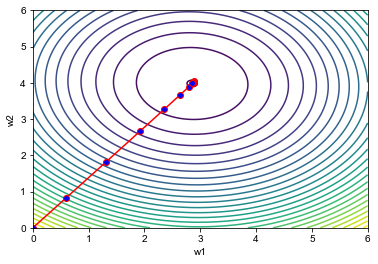

In [23]:
n = 256
w1 = np.linspace(0, 6, n)
w2 = np.linspace(0, 6, n)
Js_grid = np.zeros((n, n))
w_2d = np.zeros(2)
 
# 把w1,w2数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W1, W2 = np.meshgrid(w1, w2)

for i in range(0,n):
    w_2d[0] = w1[i]
    for j in range(0,n):
        w_2d[1] = w2[j]
        Js_grid[i,j] = obj_ols(X_train_2d, y_train_2d, w_2d)
        
    
# 等高线
plt.contour(W1, W2, Js_grid, 30)

#梯度下降轨迹
#初始化
d2 = X_train_2d.shape[1]  # 特征维度
w_start = np.zeros(d2)  #参数初始化

#梯度下降
lr = 0.1
ws_bgd, Js_bgd = bgd_NAG_ols(X_train_2d, y_train_2d, w_start, grad_OLS, lr =  lr)


ws_np_bgd = np.mat(ws_bgd)
plt.plot(ws_np_bgd[:,1], ws_np_bgd[:,0],  color='r',markerfacecolor='blue',marker='o')  

plt.xlabel(u'w1')
plt.ylabel(u'w2')
# 显示图表
plt.show()

NAG由于能提前获得信息，收敛更快

## 特征不做标准化，由于两个特征的取值范围相差较大，学习率设置得很小：0.0001

In [24]:
# 从原始数据中分离输入特征x和输出y
df = pd.read_csv(dpath + "Advertising.csv")

y = df['sales']
X = df.drop(['sales', 'Unnamed: 0', 'newspaper'], axis = 1)

#将数据分割训练数据与测试数据
# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)

#数据中心化，截距=0
X_train_mean = X_train.mean()
X_train = X_train - X_train_mean

y_train_mean = y_train.mean()
y_train = y_train - y_train_mean

### 梯度下降

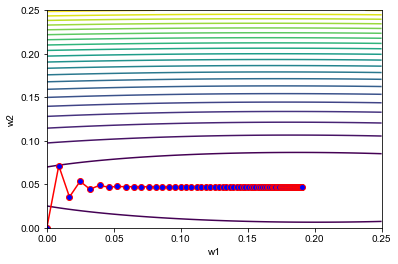

In [28]:
n = 256
w1 = np.linspace(0, 0.25, n)
w2 = np.linspace(0, 0.25, n)
Js_grid = np.zeros((n, n))

w_2d = np.zeros(2)
 
# 把w1,w2数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W1, W2 = np.meshgrid(w1, w2)

for i in range(0,n):
    w_2d[0] = w1[i]
    for j in range(0,n):
        w_2d[1] = w2[j]
        Js_grid[i,j] = obj_ols(X_train, y_train, w_2d)
    
# 等高线
plt.contour(W1, W2, Js_grid, 30)

#梯度下降轨迹
D = X_train.shape[1]  # 特征维度
w_start = np.zeros(D)  #参数初始化


lr = 0.0001
ws, Js = bgd_ols(X_train, y_train, w_start, grad_OLS, lr =  lr)


ws_np = np.mat(ws)
plt.plot(ws_np[:,1], ws_np[:,0],  color='r',markerfacecolor='blue',marker='o')  

plt.xlabel(u'w1')
plt.ylabel(u'w2')
# 显示图表
plt.show()

[0.04656358354175372, 0.19027906764383734]


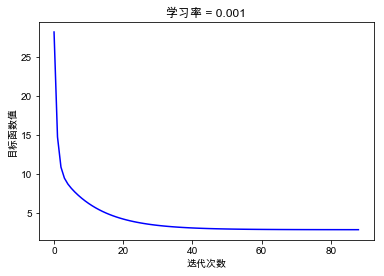

In [30]:
#lr = 0.001
n_iter = len(ws)
plt.plot(range(n_iter), Js, "b-")
plt.xlabel(u'迭代次数')
plt.ylabel(u'目标函数值')
plt.title(u'学习率 = '+ str(lr))

print(ws[n_iter-1])

### 动量法（特征不做标准化）

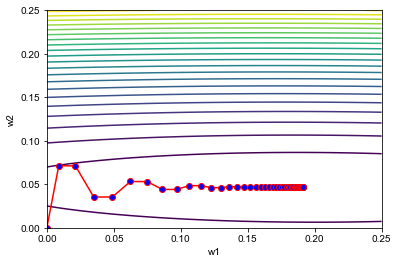

In [31]:
n = 256
w1 = np.linspace(0, 0.25, n)
w2 = np.linspace(0, 0.25, n)
Js_grid = np.zeros((n, n))

#初始值
w_2d = np.zeros(2)

 
# 把w1,w2数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W1, W2 = np.meshgrid(w1, w2)

for i in range(0,n):
    w_2d[0] = w1[i]
    for j in range(0,n):
        w_2d[1] = w2[j]
        Js_grid[i,j] = obj_ols(X_train, y_train, w_2d)
    
# 等高线
plt.contour(W1, W2, Js_grid, 30)

#梯度下降轨迹
D = X_train.shape[1]  # 特征维度
w_start = np.zeros(D)  #参数初始化

lr = 0.0001
ws, Js = bgd_momentum_ols(X_train, y_train, w_start, grad_OLS, lr = lr, rpo = 0.5)
#print(ws)

ws_np = np.mat(ws)
plt.plot(ws_np[:,1], ws_np[:,0],  color='r',markerfacecolor='blue',marker='o')  

plt.xlabel(u'w1')
plt.ylabel(u'w2')
# 显示图表
plt.show()

[0.04655642788027334, 0.19166061917661023]


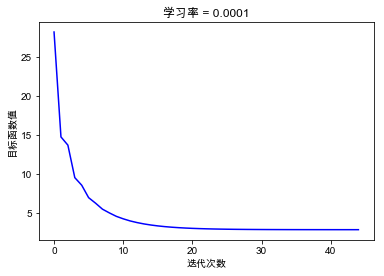

In [32]:
n_iter = len(ws)
plt.plot(range(n_iter), Js, "b-")
plt.xlabel(u'迭代次数')
plt.ylabel(u'目标函数值')
plt.title(u'学习率 = '+ str(lr))

print(ws[n_iter-1])

## Nesterov 动量法（Nesterov Accelerated Gradient, NAG）

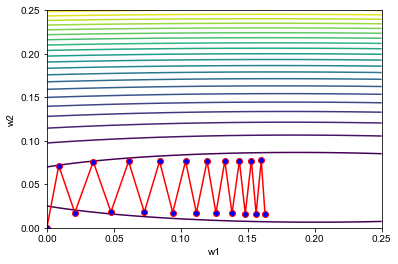

In [35]:
n = 256
w1 = np.linspace(0, 0.25, n)
w2 = np.linspace(0, 0.25, n)
Js_grid = np.zeros((n, n))
w_2d = np.zeros(2)

 
# 把w1,w2数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W1, W2 = np.meshgrid(w1, w2)

for i in range(0,n):
    w_2d[0] = w1[i]
    for j in range(0,n):
        w_2d[1] = w2[j]
        Js_grid[i,j] = obj_ols(X_train, y_train, w_2d)
    
# 等高线
plt.contour(W1, W2, Js_grid, 30)

#梯度下降轨迹
D = X_train.shape[1]  # 特征维度
w_start = np.zeros(D)  #参数初始化

#lr = 0.00005
lr = 0.0001
ws, Js = bgd_NAG_ols(X_train, y_train, w_start, grad_OLS, lr = lr, rpo = 0.5)
#print(ws)

ws_np = np.mat(ws)
plt.plot(ws_np[:,1], ws_np[:,0],  color='r',markerfacecolor='blue',marker='o')  

plt.xlabel(u'w1')
plt.ylabel(u'w2')
# 显示图表
plt.show()

[0.015737717488950545, 0.16295276020441876]


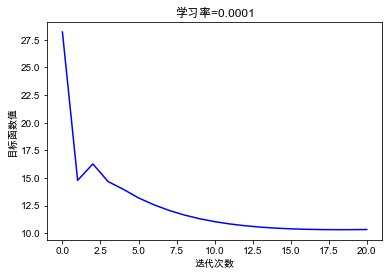

In [36]:
n_iter = len(ws)
plt.plot(range(n_iter), Js, "b-")
plt.xlabel(u'迭代次数')
plt.ylabel(u'目标函数值')
plt.title(u'学习率='+ str(learning_rate))

print(ws[n_iter-1])

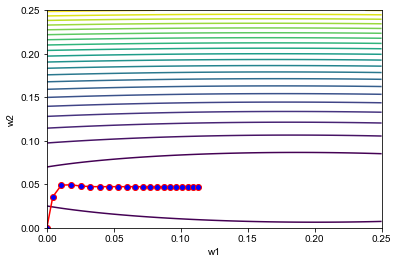

In [37]:
n = 256
w1 = np.linspace(0, 0.25, n)
w2 = np.linspace(0, 0.25, n)
Js_grid = np.zeros((n, n))
w_2d = np.zeros(2)

 
# 把w1,w2数据生成mesh网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
W1, W2 = np.meshgrid(w1, w2)

for i in range(0,n):
    w_2d[0] = w1[i]
    for j in range(0,n):
        w_2d[1] = w2[j]
        Js_grid[i,j] = obj_ols(X_train, y_train, w_2d)
    
# 等高线
plt.contour(W1, W2, Js_grid, 30)

#梯度下降轨迹
D = X_train.shape[1]  # 特征维度
w_start = np.zeros(D)  #参数初始化

lr = 0.00005
ws, Js = bgd_NAG_ols(X_train, y_train, w_start, grad_OLS, lr = lr, rpo = 0.5)
#print(ws)

ws_np = np.mat(ws)
plt.plot(ws_np[:,1], ws_np[:,0],  color='r',markerfacecolor='blue',marker='o')  

plt.xlabel(u'w1')
plt.ylabel(u'w2')
# 显示图表
plt.show()

[0.04696228014759041, 0.11318741288531205]


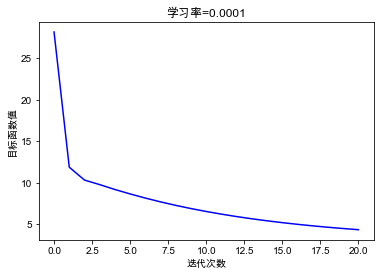

In [38]:
n_iter = len(ws)
plt.plot(range(n_iter), Js, "b-")
plt.xlabel(u'迭代次数')
plt.ylabel(u'目标函数值')
plt.title(u'学习率='+ str(learning_rate))

print(ws[n_iter-1])